# **Task \#4 A**: Machine Learning MC886/MO444
## **Convolution Models and Transfer Learning**

In [ ]:
print('Daniel Gardin Gratti ' + '214729')
print('Beatriz Cardoso Nascimento' + ' 247403')

Daniel Gardin Gratti 214729
Beatriz Cardoso Nascimento 247403


## Objective:

The objective of this project is to implement alternative approaches to **Convolutional Neural Networks** (CNNs) and **Transfer Learning Techniques** in order to devise the most effective model for addressing the given problems.

**Obs: In this work, you can use scikit-learn and PyTorch.**

## Dataset

The COCO (Common Objects in Context) dataset is a widely used benchmark dataset in computer vision research. It serves as a valuable resource for various tasks including object recognition, segmentation, and captioning. The dataset comprises a vast collection of images, each meticulously annotated with detailed information about the objects present in the image. It covers a diverse range of object categories, encompassing everyday objects such as people, animals, vehicles, and household items.

Dataset Information:

- The dataset consists of approximately 115,000 images. However, for your convenience, you can work with a subset that contains at least 30,000 images. You can utilize the function get_partial_dataset to create this partial dataset.

- The following code cell will download the dataset, but please note that if the runtime gets disconnected, you will need to download it again. In case the authorization key doesn't work, you can download the dataset from the links provided below.

- The data is available at: ([Link of the Dataset](https://drive.google.com/drive/folders/12dZ4lkKkAZ6CKcvDtwzXSLrYOy_avWW8?usp=sharing)): ```Multiclass Classfication``` and ```COCO JSON```


More information about the dataset: *Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." Computer Vision–ECCV 2014: 13th European Conference, Zurich, Switzerland, September 6-12, 2014, Proceedings, Part V 13. Springer International Publishing, 2014.*

In [36]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PC7C0OgcwORQZl8Ig6Uil5BR7qYeqzji' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1PC7C0OgcwORQZl8Ig6Uil5BR7qYeqzji" -O coco-multiclass.tar.gz
!tar -xf /kaggle/working/coco-multiclass.tar.gz
!rm coco-multiclass.tar.gz

--2023-07-03 01:48:02--  https://docs.google.com/uc?export=download&confirm=t&id=1PC7C0OgcwORQZl8Ig6Uil5BR7qYeqzji
Resolving docs.google.com (docs.google.com)... 108.177.127.138, 108.177.127.102, 108.177.127.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9oh5h2r3arpe5j9m9cv6k2u5kqp2ba19/1688348850000/01089768076506809926/*/1PC7C0OgcwORQZl8Ig6Uil5BR7qYeqzji?e=download&uuid=17918eea-9fbd-402a-9b7c-751af516c457 [following]
--2023-07-03 01:48:02--  https://doc-08-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9oh5h2r3arpe5j9m9cv6k2u5kqp2ba19/1688348850000/01089768076506809926/*/1PC7C0OgcwORQZl8Ig6Uil5BR7qYeqzji?e=download&uuid=17918eea-9fbd-402a-9b7c-751af516c457
Resolving doc-08-3s-docs.googleusercontent.com (doc-08-3s-docs.googleusercontent.com)... 173.194.79.1

## Libraries

In [37]:
import os
import gc
import cv2
import json
import torch
import numpy as np
from glob import glob
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from torchvision import models
from tqdm.notebook import tqdm
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import Resize, Compose, ToTensor, Normalize, ColorJitter, Pad, RandomRotation, RandomHorizontalFlip
from torch.utils.data import Dataset, DataLoader

## Classification Task with COCO

In the COCO dataset, each sample can have multiple labels. Therefore, using the CrossEntropy loss function, which relies on softmax activation, is not suitable for the multi-label classification problem. Let's explore why CrossEntropy is not appropriate in this case.

![loss_definition_1](https://drive.google.com/uc?export=view&id=1BDkR2n6aNq6VvXnQNYw7dxtzfveijysB)

The above image illustrates how we calculate the CrossEntropy loss in a simple multi-class classification scenario, where the target labels are mutually exclusive. The loss computation focuses on the logit corresponding to the true target label and its relative magnitude compared to other labels. However, softmax ensures that all predicted probabilities sum to 1, making it impossible to have several correct answers.

![loss_definition_2](https://drive.google.com/uc?export=view&id=1tMQ0WFY1HAIlBnp3bSVic4gy1GJuJyc4)

To address this, we need to treat each prediction independently. One solution is to use the Sigmoid function as a normalizer for each logit value individually. This way, we can have multiple correct labels and their respective predicted probabilities for each label. We can then compare these probabilities with the probabilities of the correct labels (set to 1) using the BinaryCrossEntropy loss.

![loss_definition_3](https://drive.google.com/uc?export=view&id=1Mp5lo3EFEM7vMNE_5TM-Zts1NgY8oTrn)

Hence, the appropriate solution is to use the BinaryCrossEntropy loss.

**Consequently, models should have sigmoid as the last activation function to handle multi-label classification tasks correctly.**

In [38]:
## ----- Global Variables ----- ##
batch_size      = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


### Auxiliar functions


In [39]:
def get_partial_dataset(path, save_filename='partial_dataset', n_samples=30000):
    '''
        Creates a partial dataset for training

        Parameters
        ----------
        path : str
        Path to the _classes.csv file.

        save_filename : str
        Name of the file to be saved.

        n_samples : int
        Specifies the number of samples for training.
    '''

    df = pd.read_csv(path)
    idxs = []

    # --- Remove samples without class labels --- #
    for i, row in df.iterrows():
        if row[1:].sum() == 0:
            idxs.append(i)

    df.drop(idxs, inplace=True)

    # --- Randomly remove samples --- #
    idxs = df.sample(df.shape[0] - n_samples).index
    df   = df.drop(idxs).reset_index(drop=True)

    # --- Save locally --- #
    # Include the Google Drive path to ensure the preservation of this information!
    df.to_csv(f'{save_filename}.csv', index=False)

get_partial_dataset('/kaggle/working/COCO-multiclass/train/full_dataset.csv', '/kaggle/working/COCO-multiclass/partial_dataset', n_samples=30000)

### Class Dataset and DataLoader

*Obs: Learn more in [Dataset and Dataloader Tutorial Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)*

In [40]:
class COCOMulticlass(Dataset):
    '''
    Dataset class

    Parameters:
    -----------
    __init__():
      annotations_file : str
        Path to the _classes.csv file or partial_dataset.csv file

      img_dir : str
        Path to the directory containing the images

      transform : torchvision.transforms
        Image transformations from the torchvision library.
    '''

    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir    = img_dir
        self.transform  = transform
        self.classes_names = self.img_labels.columns[1:]


    def __len__(self):
        return len(self.img_labels)


    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image    = Image.open(img_path)
        label    = torch.Tensor(self.img_labels.iloc[idx, 1:].values.astype(float))

        if self.transform:
            image = self.transform(image)

        return image, label


def inverse_normalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)

    x = tensor.clone()
    x.mul_(std).add_(mean)
    return x

In [41]:
# --- Image transformations --- #
data_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# --- Datasets --- #
train_dataset = COCOMulticlass('COCO-multiclass/partial_dataset.csv', 'COCO-multiclass/train', transform=data_transform)
valid_dataset = COCOMulticlass('COCO-multiclass/valid/_classes.csv', 'COCO-multiclass/valid', transform=data_transform)

# --- DataLoaders --- #

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

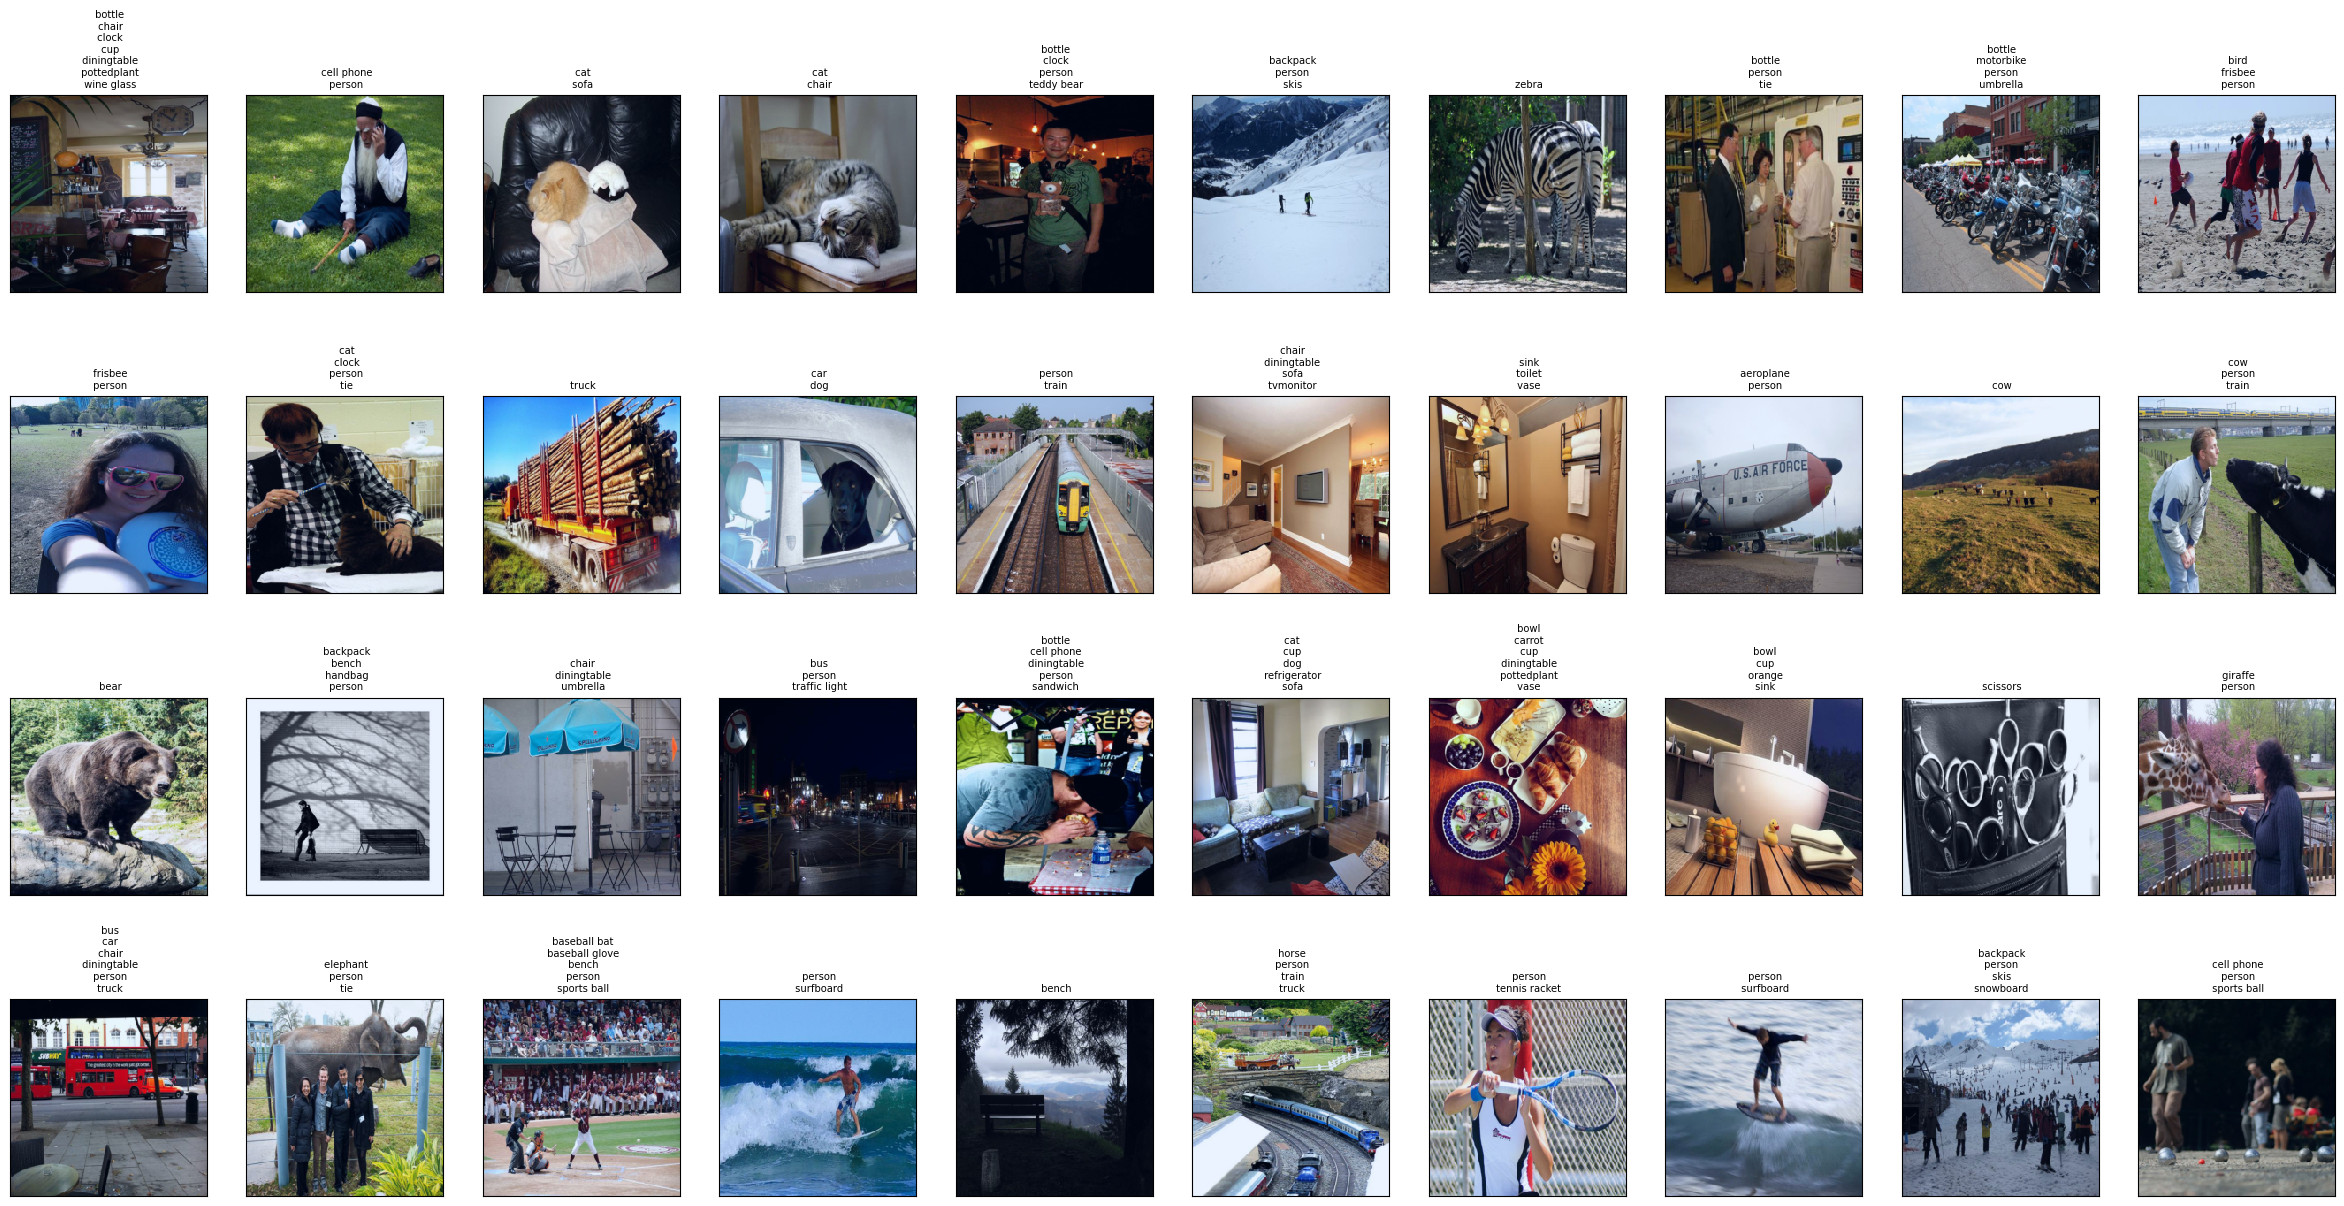

In [42]:
df = pd.read_csv('/kaggle/working/COCO-multiclass/partial_dataset.csv')
class_names = df.columns[1:]

## ------ Plot Data ----- ##
fig, axes = plt.subplots(4, 10, figsize=(30,15), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    data, target = train_dataset.__getitem__(i*10)

    image = data.permute(1, 2, 0).numpy()
    image = 255 * (image - np.min(image))/(np.max(image)-np.min(image))
    image = image.astype('uint8')
    ax.imshow(image, cmap='binary', interpolation='nearest')
    ax.set_title('\n'.join(class_names[target == 1]))

## Checking if dataset is balanced

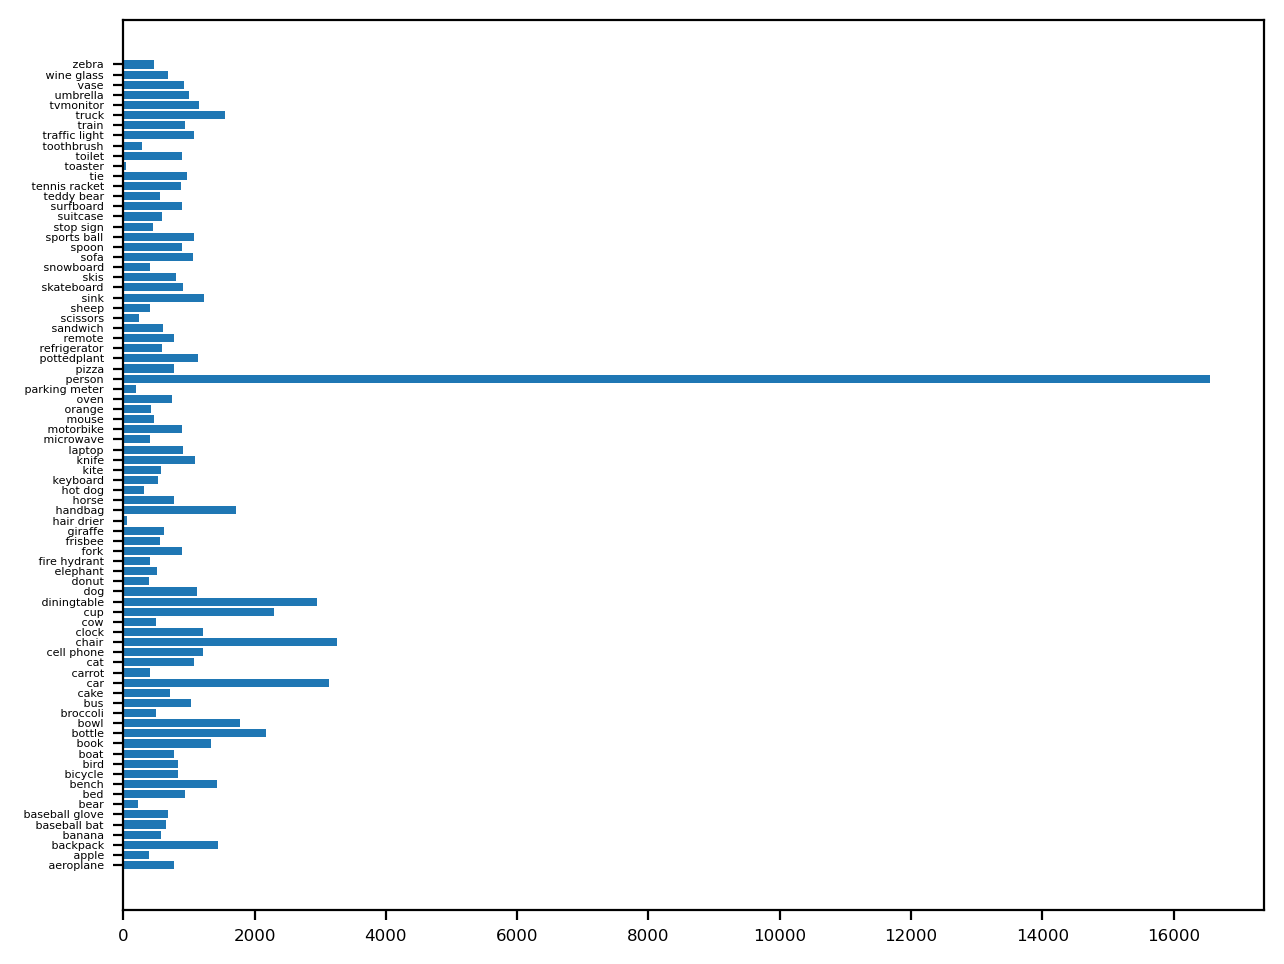

In [43]:
distr = df.drop(columns=['filename']).sum().to_numpy()

fig, ax = plt.subplots(dpi=200)

plt.barh(class_names, distr)

freqs = distr.sum()/distr
freqs = freqs/freqs.sum()

plt.yticks(fontsize=4)
fig.tight_layout()

plt.show()

Ao visualizar a distribuição de classes nas imagens de treino podemos ver que o dataset é extremamente desbalanceado, havendo muito mais imagens com rótulo de pessoa que as demais. Isso é um grande desafio e, para tentar minimizar este efeito, penalizamos, na função de perda, de forma que a perda por classe seja proporcional ao inverso de sua frequência no dataset, aumentando a perda para classes menos frequentes e diminuindo para classes mais frequentes.

### 1. (3 points) Buil and train a Convolutional Neural Network (CNN) for Multi-Label Image Classification.

*Tip 1: Apply a weight regularization to avoid overfitting and improve the performance of the CNN (for example, l1, l2, l1 and l2).*

*Tip 2: Remember to use regularization layers, such as Dropout, BatchNorm and LayerNorm.*

In [ ]:
@torch.no_grad()
def evaluate(logit, target, threshold=0.5):
    pred = torch.where(logit > threshold, 1, 0)
    acc = (torch.count_nonzero(pred == target)/torch.numel(target)).item()

    TP = (pred * target).sum()
    FP = (pred * (1 - target)).sum()
    FN = ((1 - pred) * target).sum()

    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)

    return {'accuracy': acc,
            'precision': precision.item(),
            'recall': recall.item(),
            'f1 score': f1.item()}


def metrics2string(metrics):
    return '   '.join([f"{metric} {value : >2.2%}" for metric, value in metrics.items()])


def criterion(pred, target, class_weights):
    ce = nn.BCELoss(reduction='none')
    loss = (ce(pred, target) * torch.tensor(class_weights, device=device)).mean()

    return loss

In [ ]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs):
    gc.collect()
    torch.cuda.empty_cache()

    device = next(model.parameters()).device

    history = []
    val_history = []

    n_batches = len(train_loader)
    for epoch in range(epochs):
        model.train()

        epoch_history = []
        for n_batch, (data, target) in enumerate(train_loader):
            data    = data.to(device)
            target  = target.to(device)

            pred = model(data)

            loss = criterion(pred, target, freqs)

            metrics = evaluate(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            print(f'\rEPOCH {epoch + (n_batch+1)/n_batches : >05.3f} |   loss: {loss.item() : >1.3}   {metrics2string(metrics)}         ', end='')

            metrics['loss'] = loss.item()

            epoch_history.append(metrics)


        history.append(epoch_history)

        epoch_metric = {metric : np.mean([hist[metric] for hist in epoch_history]) for metric in metrics.keys()}
        epoch_loss   = epoch_metric.pop('loss')
        with torch.no_grad():
            model.eval()
            val_bucket = []
            val_losses = 0
            for data, target in valid_loader:
                data    = data.to(device)
                target  = target.to(device)

                pred = model(data)

                val_loss  = criterion(pred, target, freqs)
                val_losses += val_loss.item()

                metrics = evaluate(pred, target)
                val_bucket.append(metrics)

                print(f'\rEPOCH {epoch + (n_batch+1)/n_batches : >02.3} |   loss: {epoch_loss : >1.3}   {metrics2string(epoch_metric)}  | Validation:  loss: {val_loss : >01.3}   {metrics2string(metrics)}    ', end='')

        val_metric = {metric : np.mean([hist[metric] for hist in val_bucket]) for metric in metrics.keys()}
        val_losses /= len(valid_loader)

        print(f'\rEPOCH {epoch + (n_batch+1)/n_batches : >02.3} |   loss: {epoch_loss : >1.3}   {metrics2string(epoch_metric)}  | Validation:  loss: {val_losses : >01.3}   {metrics2string(val_metric)}     ', end='')
        print()

        val_metric['loss'] = val_losses

        val_history.append(val_metric)

    return history, val_history


In [ ]:
def plot_history(history, val_history, model_name):
    fig, ax = plt.subplots(1, 2, figsize=(20,7))

    for epoch in range(len(history)):
        epochs = np.linspace(epoch, epoch+1, num=len(history[epoch]), endpoint=False)

        ax[0].plot(epochs, [metrics['loss'] for metrics in history[epoch]], 'b', alpha=0.4)
        ax[1].plot(epochs, [metrics['f1 score'] for metrics in history[epoch]], 'b', alpha=0.4)

    # Cuidado: Gambiarra!
    ax[0].plot(range(1, len(history)+1), [np.mean([metrics['loss'] for metrics in history[epoch]]) for epoch in range(len(history))], 'b', linewidth=4, label="Train")
    ax[1].plot(range(1, len(history)+1), [np.mean([metrics['f1 score'] for metrics in history[epoch]]) for epoch in range(len(history))], 'b', linewidth=4, label="Train")
    ax[0].plot(range(1, len(val_history)+1), [metrics['loss'] for metrics in val_history], 'orange', label="Validation",linewidth=4)
    ax[1].plot(range(1, len(val_history)+1), [metrics['f1 score'] for metrics in val_history], 'orange', label="Validation", linewidth=4)

    ax[0].set_title(f"{model_name} loss per batch/epoch")
    ax[1].set_title(f"{model_name} F1 Score per batch/epoch")
    ax[1].legend()

    plt.show()

In [ ]:
def show_prediction(model, dataset, class_names):
    '''
    Show a sample prediction.

    Parameters:
    -----------
    model : nn.Module
    Model to be evaluated.

    dataloader : dataloader
    DataLoader for the example.

    class_names : list
    List containing the class names.

    '''
    idx = np.random.randint(len(dataset))

    data, target = dataset[idx]
    data = data[None, :].to(device)
    logits = model(data)[0]
    pred   = torch.where(logits > .5, 1, 0).detach().cpu().numpy()
    target = target.cpu().numpy()
    plt.imshow(inverse_normalize(data[0]).permute(1,2,0).cpu())
    plt.axis('off')
    plt.show()

    target = ''.join(class_names[target == 1])
    pred   = ''.join(class_names[pred == 1])
    print(f"Target: {target}\nPred: {pred if len(pred) != 0 else 'NONE'}")

### Treinando modelo HandcraftCNN_v1

In [45]:
class HandcraftCNN_v1(nn.Module):
    def __init__(self):
        super(HandcraftCNN_v1, self).__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(16, 32, kernel_size=3, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(32, 64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(64, 128, kernel_size=3, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(128, 256, kernel_size=3, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(256, 512, kernel_size=3, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU()
        )

        self.global_pool = nn.Sequential(

                        nn.AdaptiveAvgPool2d((1,1))

        )

        self.classifier = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(512, 80),
                        nn.Sigmoid()
        )


    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)

        return x


In [ ]:
model_v1 = HandcraftCNN_v1()
data, target = next(iter(train_loader))

logits = model_v1(data)

assert logits.shape == (batch_size, len(class_names)), 'The output shape is incorrect.'

optimizer = torch.optim.AdamW(model_v1.parameters(), lr=1e-2, weight_decay=1e-5)

history, val_history = train(model_v1.to(device), train_loader, valid_loader, optimizer=optimizer, criterion=criterion, epochs=30)

EPOCH 1.0 |   loss: 0.000959   accuracy 96.41%   precision 59.54%   recall 13.40%   f1 score 21.40%  | Validation:  loss: 0.000894   accuracy 96.51%   precision 60.14%   recall 14.47%   f1 score 23.23%     
EPOCH 2.0 |   loss: 0.000857   accuracy 96.55%   precision 64.41%   recall 14.61%   f1 score 23.62%  | Validation:  loss: 0.000849   accuracy 96.58%   precision 64.14%   recall 15.08%   f1 score 24.29%     
EPOCH 3.0 |   loss: 0.00081   accuracy 96.61%   precision 66.36%   recall 16.64%   f1 score 26.39%  | Validation:  loss: 0.000798   accuracy 96.63%   precision 62.13%   recall 20.47%   f1 score 30.61%     
EPOCH 4.0 |   loss: 0.000777   accuracy 96.69%   precision 68.66%   recall 18.88%   f1 score 29.40%  | Validation:  loss: 0.000786   accuracy 96.66%   precision 66.68%   recall 18.00%   f1 score 28.07%     
EPOCH 5.0 |   loss: 0.000746   accuracy 96.73%   precision 69.50%   recall 20.68%   f1 score 31.61%  | Validation:  loss: 0.00077   accuracy 96.64%   precision 66.06%   reca

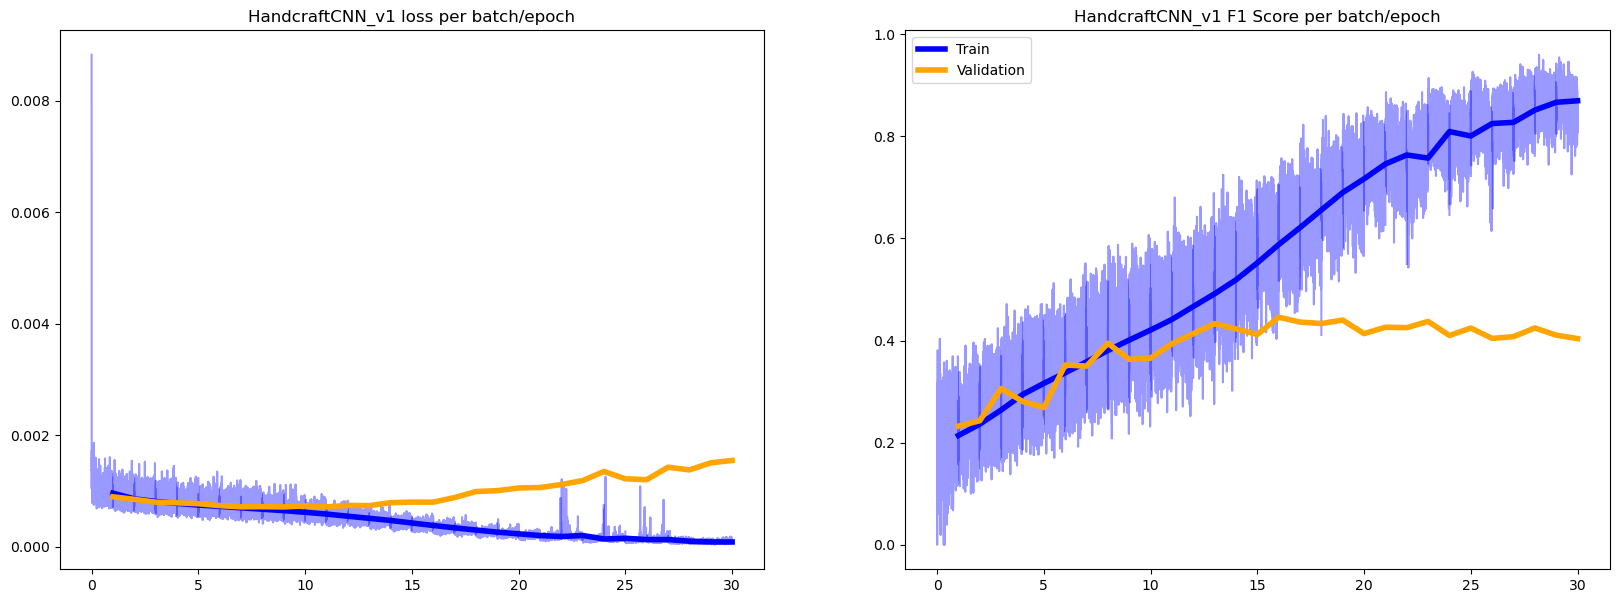

In [ ]:
plot_history(history, val_history, 'HandcraftCNN_v1')

### Visualize model predictions

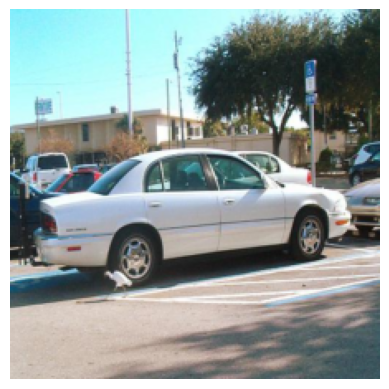

Target:  bird car truck
Pred:  car person truck


In [ ]:
show_prediction(model_v1, valid_dataset, class_names)

### Treinando modelo HandcraftCNN_v2


In [44]:
class HandcraftCNN_v2(nn.Module):
    def __init__(self):
        super(HandcraftCNN_v2, self).__init__()
        self.features = nn.Sequential(
                        nn.Conv2d(3, 8, kernel_size=3, padding=1),
                        nn.BatchNorm2d(8),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(8, 16, kernel_size=3, padding=1),
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(16, 32, kernel_size=3, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(32, 64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(64, 128, kernel_size=3, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(128, 256, kernel_size=3, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
                        nn.Conv2d(256, 512, kernel_size=3, padding=1),
                        nn.BatchNorm2d(512),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2),
        )


        self.classifier = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(512, 1024),
                        nn.ReLU(),
                        nn.Linear(1024, 80),
                        nn.Sigmoid()
        )


    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x


In [ ]:
model_v2 = HandcraftCNN_v2()
data, target = next(iter(train_loader))

logits = model_v2(data)

assert logits.shape == (batch_size, len(class_names)), 'The output shape is incorrect.'

optimizer = torch.optim.AdamW(model_v2.parameters(), lr=1e-2, weight_decay=1e-3)

history, val_history = train(model_v2.to(device), train_loader, valid_loader, optimizer=optimizer, criterion=criterion, epochs=30)

EPOCH 1.0 |   loss: 0.00128   accuracy 96.38%   precision 55.51%   recall 14.53%   f1 score 22.51%  | Validation:  loss: 0.000958   accuracy 96.47%   precision 57.57%   recall 13.94%   f1 score 22.33%     
EPOCH 2.0 |   loss: 0.000921   accuracy 96.48%   precision 60.06%   recall 13.96%   f1 score 22.49%  | Validation:  loss: 0.000895   accuracy 96.49%   precision 67.62%   recall 7.88%   f1 score 14.01%      
EPOCH 3.0 |   loss: 0.000873   accuracy 96.53%   precision 63.65%   recall 13.87%   f1 score 22.59%  | Validation:  loss: 0.000853   accuracy 96.55%   precision 61.49%   recall 15.51%   f1 score 24.64%     
EPOCH 4.0 |   loss: 0.000838   accuracy 96.56%   precision 64.72%   recall 14.95%   f1 score 24.12%  | Validation:  loss: 0.000829   accuracy 96.59%   precision 65.01%   recall 14.98%   f1 score 24.22%     
EPOCH 5.0 |   loss: 0.000813   accuracy 96.59%   precision 65.39%   recall 16.12%   f1 score 25.68%  | Validation:  loss: 0.000815   accuracy 96.59%   precision 62.55%   rec

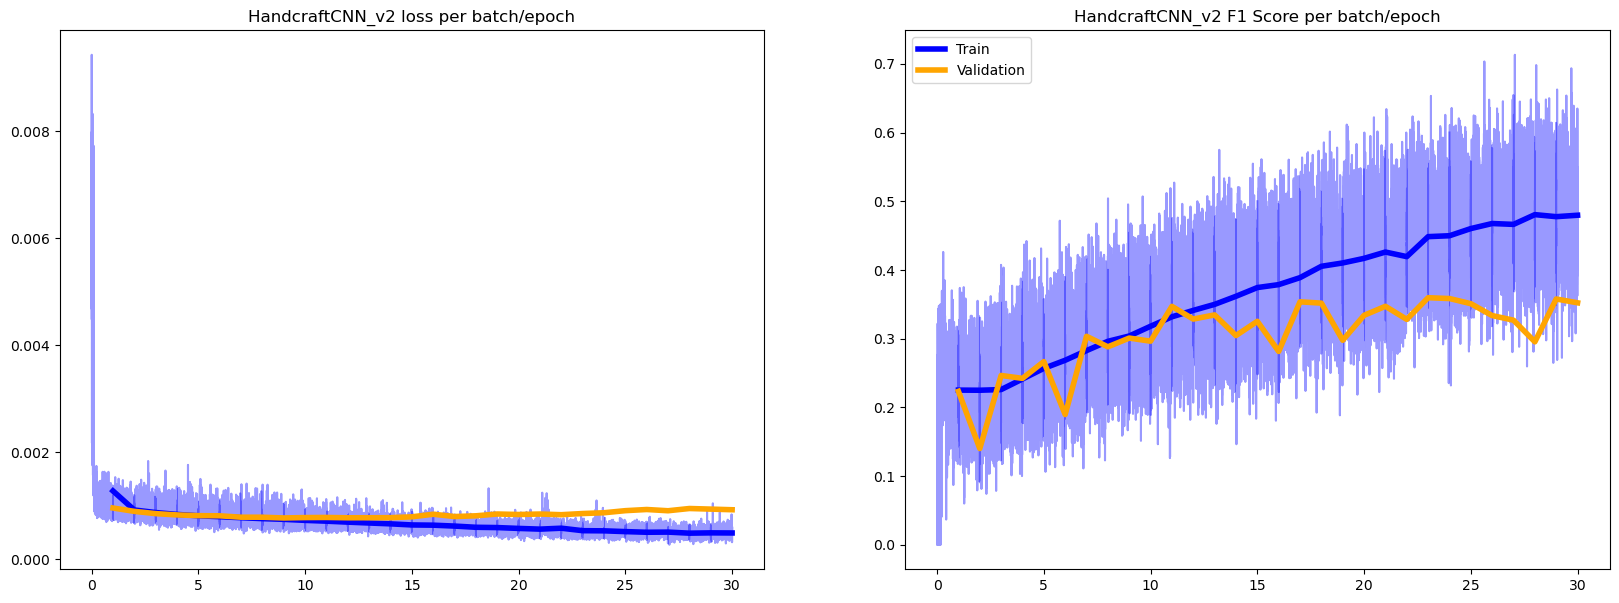

In [ ]:
plot_history(history, val_history, 'HandcraftCNN_v2')

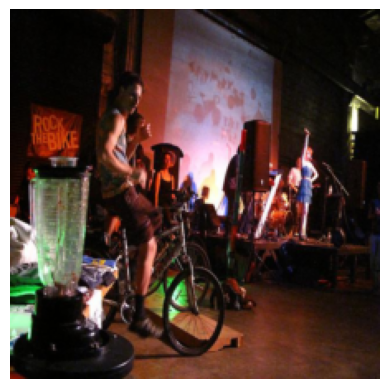

Target:  bicycle person tvmonitor
Pred:  person


In [ ]:
show_prediction(model_v2, valid_dataset, class_names)

 > What are the conclusions? Was this model sufficient for the task? Do the hyperparameters, such as learning rate, batch size, and others, impact the final result? (1-2 paragraphs)

 Podemos verificar pelos experimentos acima que ambos os modelos não foram suficientes para realizar a tarefa proposta pois não atingiram o desempenho necessário para distinguir bem múltiplas classes. Na primeira CNN, o exemplo que exibimos tinha como label "bird car truck", no entanto previu "car person truck". Observamos que o modelo teve duas classes verdadeiras positivas (car, truck) e uma falsa positiva (person). Nele, obtivemos uma precisão, ou seja, um número de verdadeiros positivos em relação à soma de verdadeiros e falsos positivos, de 53.83%. Isso significa que, ao identificar determinada classe, acertamos cerca de metade das vezes. Isso nos indica que nosso modelo não obteve um resultado ideal. Analisando as curvas de aprendizado, podemos ver que a rede sofreu de overfitting, pois o erro no conjunto de treinamento continuou decrescendo, chegando a um F1 Score de 80%, mas o conjunto de validação estagnou próximo a 40% de F1 Score. Isso mostra que a rede não generalizou, provavelmente devido a dificuldade da tarefa e falta de variabilidade intra-classe em algumas classes, que unido com sua baixa representatividade, causou a baixa performance da rede.
 
A imagem confirma este comportamento, que classificou corretamente classes com maior representatividade (car e truck), previu uma classe extramamente distoante (person) para tentar buscar performance e não conseguiu prever uma classe de baixa representatividade (bird).
 
  Na segunda CNN, o efeito é mais próximo de underfitting, que não conseguiu convergir nem para o conjunto de treino nem para o conjunto de validação, muito provavelmente devido a arquitetura e escolha de hiperparâmetros, que influenciam muito no resultado final. A escolha do learning rate está diretamente ligada à convergência ou não do modelo, pois se estiver muito alto pode causar overshooting, e se for muito pequeno pode fazer com que o modelo demore muito a convergir e seja muito mais caro computacionalmente. Já a escolha do tamanho do batch também é essencial, pois ao escolher um batch grande, temos um treinamento mais rápido, porém possivelmente menos preciso. Um batch menor leva o modelo a convergir mais lentamente mas pode ajudá-lo a encontrar uma melhor solução para a otimização da função objetivo. Além disso, outros hiperparâmetros como a arquitetura da rede (a quantidade de camadas convolucionais, por exemplo), o algoritmo de otimização e a regularização também são aspectos que influenciam no desempenho final do modelo.

### 2. (3 points) Apply the Transfer Learning Technique by utilizing one of the pre-trained CNN models available in PyTorch as backbone.

In [ ]:
## TODO: Load a pre-trained convolutional model and fine-tune it on the COCO dataset
# Link: https://pytorch.org/vision/stable/models.html

class TransferLearningModel(nn.Module):
    def __init__(self):
        super(TransferLearningModel, self).__init__()

        backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]

        self.features = nn.Sequential(*layers)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_filters, 80),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.features(x)
        x = nn.Flatten()(x)
        x = self.classifier(x)

        return x


In [ ]:
model_tf = TransferLearningModel().to(device)

data, target = next(iter(train_loader))
logits = model_tf(data.to(device))

assert logits.shape == (batch_size, len(class_names)), 'Output Shape incorrect'

for param in model_tf.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(model_tf.parameters(), lr=1e-1, weight_decay=0.0005)

history, val_history = train(model_tf, train_loader, valid_loader, optimizer=optimizer, criterion=criterion, epochs=10)

for param in model_tf.features.parameters():
    param.requires_grad = True


optimizer = torch.optim.SGD(model_tf.parameters(), lr=5e-3, momentum=0.9, weight_decay=0.0005)

print("Start Finetuning")
history, val_history = train(model_tf, train_loader, valid_loader, optimizer=optimizer, criterion=criterion, epochs=30)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.2MB/s]


EPOCH 1.0 |   loss: 0.0177   accuracy 96.91%   precision 71.41%   recall 28.78%   f1 score 40.53%  | Validation:  loss: 0.0165   accuracy 97.14%   precision 74.34%   recall 33.80%   f1 score 46.26%     
EPOCH 2.0 |   loss: 0.0172   accuracy 97.13%   precision 74.12%   recall 33.85%   f1 score 46.24%  | Validation:  loss: 0.017   accuracy 96.97%   precision 66.21%   recall 35.71%   f1 score 46.23%     
EPOCH 3.0 |   loss: 0.0169   accuracy 97.19%   precision 74.19%   recall 35.92%   f1 score 48.13%  | Validation:  loss: 0.0162   accuracy 97.21%   precision 74.80%   recall 36.51%   f1 score 48.84%     
EPOCH 4.0 |   loss: 0.0167   accuracy 97.24%   precision 73.73%   recall 38.75%   f1 score 50.55%  | Validation:  loss: 0.016   accuracy 97.33%   precision 77.93%   recall 38.11%   f1 score 51.00%      
EPOCH 5.0 |   loss: 0.0164   accuracy 97.29%   precision 73.55%   recall 40.76%   f1 score 52.21%  | Validation:  loss: 0.0162   accuracy 97.24%   precision 71.03%   recall 42.23%   f1 scor

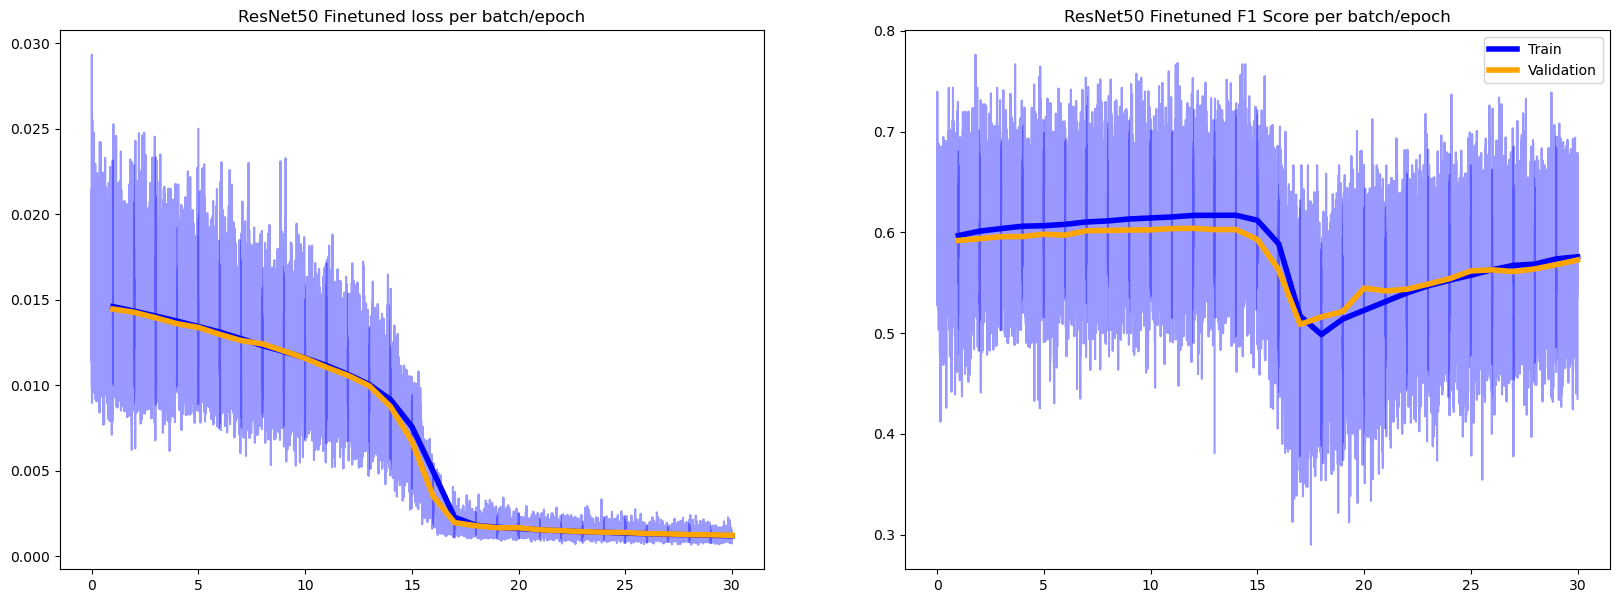

In [ ]:
plot_history(history, val_history, 'ResNet50 Finetuned')

### Visualize model predictions

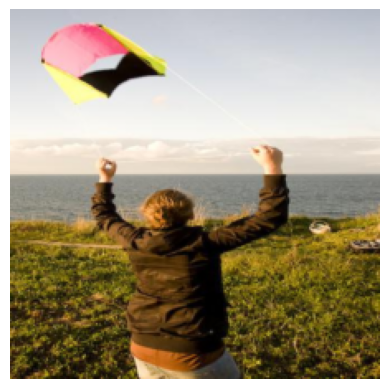

Target:  kite person
Pred:  person


In [68]:
show_prediction(model_tf, valid_dataset, class_names)

 > What are the conclusions? Does the performance improve? Is it better to freeze the entire model or update all the weights in this case? (1-2 paragraphs)
 
 A estratégia utilizada foi iniciar com um treinamento com o backbone congelado por 10 épocas e depois realizar o fine-tuning para tentar obter performance. A curva de aprendizado da rede teve um comportamento inesperado, modificando sua tendência por volta da época 15. O modelo obteve um F1 score superior às redes anteriores no conjunto de validação e não parece ter sofrido underfitting, provavelmente uma escolha melhor de learning rate e otimizador poderia ter ajudado na convergência, além de mais dados de treino para obter variabilidade para ultrapassar as dificuldades do desbalanceamento.

### 3. (3 points) Apply the Data Augmentation technique to either the handcrafted model or the transfer learning model.

*Tip: Be careful to choose appropriate transformations that do not destroy the information of the sample.*

In [46]:
## TODO: Implement data augmentation during training. Choose appropriate transformations.
# Link: https://pytorch.org/vision/stable/transforms.html

train_transforms = Compose([
        ColorJitter(brightness=(0.7,1), contrast=0.3,saturation=0.5, hue=0.1),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        Pad([7,]),
        RandomRotation(15),
        Resize((224, 224), antialias=True),
        ])

valid_transforms = None

train_dataset = COCOMulticlass('/kaggle/working/COCO-multiclass/train/partial_dataset.csv', '/kaggle/working/COCO-multiclass/train', transform=train_transforms)
valid_dataset = COCOMulticlass('/kaggle/working/COCO-multiclass/valid/_classes.csv', '/kaggle/working/COCO-multiclass/valid', transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

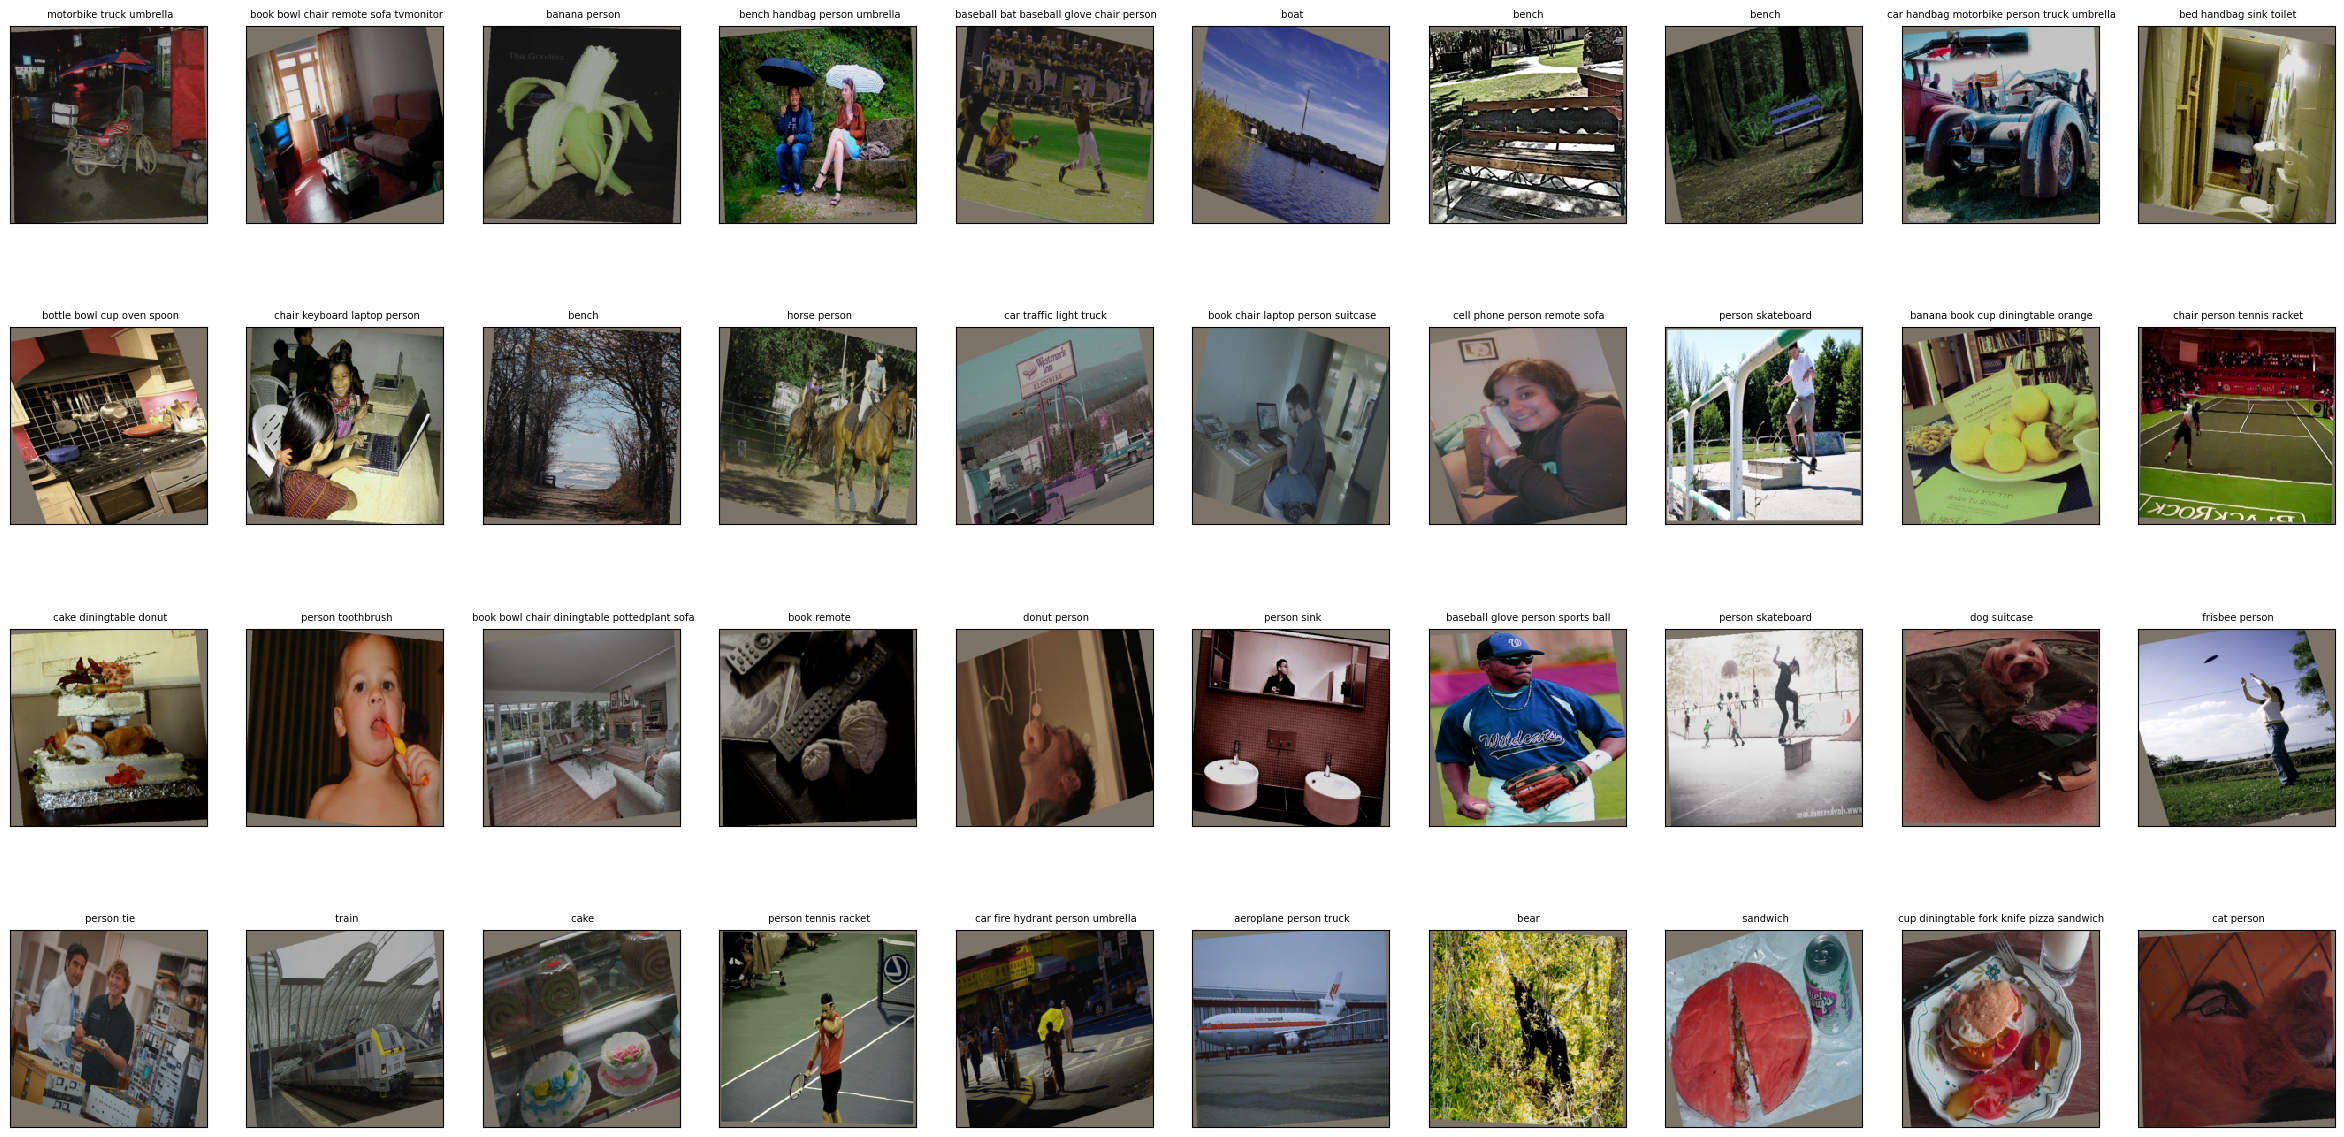

In [47]:
## ------ Plot Data ----- ##
fig, axes = plt.subplots(4, 10, figsize=(30,15), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    data, target = train_dataset.__getitem__(i*10)
    data = (inverse_normalize(data) * 255).int()
    ax.imshow(data.permute(1,2,0), cmap='binary', interpolation='nearest')
    ax.set_title(''.join(class_names[target == 1]))


In [ ]:
model_tf = TransferLearningModel().to(device)

data, target = next(iter(train_loader))
logits = model_tf(data.to(device))

assert logits.shape == (batch_size, len(class_names)), 'Output Shape incorrect'

for param in model_tf.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.AdamW(model_tf.parameters(), lr=1e-1, weight_decay=0.0005)

history, val_history = train(model_tf, train_loader, valid_loader, optimizer=optimizer, criterion=criterion, epochs=10)

for param in model_tf.features.parameters():
    param.requires_grad = True


optimizer = torch.optim.SGD(model_tf.parameters(), lr=5e-3, momentum=0.9, weight_decay=0.0005)

print("Start Finetuning")
history, val_history = train(model_tf, train_loader, valid_loader, optimizer=optimizer, criterion=criterion, epochs=30)

EPOCH 1.0 |   loss: 0.0188   accuracy 96.84%   precision 77.63%   recall 22.06%   f1 score 33.88%  | Validation:  loss: 0.0169   accuracy 97.01%   precision 75.75%   recall 26.82%   f1 score 39.38%     
EPOCH 2.0 |   loss: 0.018   accuracy 97.00%   precision 74.82%   recall 27.75%   f1 score 40.25%  | Validation:  loss: 0.0165   accuracy 97.09%   precision 75.46%   recall 30.85%   f1 score 43.53%     
EPOCH 3.0 |   loss: 0.0174   accuracy 97.09%   precision 75.37%   recall 30.97%   f1 score 43.64%  | Validation:  loss: 0.0162   accuracy 97.19%   precision 75.51%   recall 34.74%   f1 score 47.31%     
EPOCH 4.0 |   loss: 0.0172   accuracy 97.12%   precision 74.01%   recall 33.87%   f1 score 46.21%  | Validation:  loss: 0.0162   accuracy 97.20%   precision 74.23%   recall 36.46%   f1 score 48.64%     
EPOCH 5.0 |   loss: 0.0168   accuracy 97.18%   precision 73.45%   recall 36.70%   f1 score 48.68%  | Validation:  loss: 0.0158   accuracy 97.29%   precision 74.47%   recall 39.65%   f1 scor

 > What are the conclusions? Does the performance improve? (1-2 paragraphs)
 
Tentamos utilizar o transfer learning utilizando o data augmentation. Infelizmente, a tarefa tornou-se muito custosa computacionalmente devido a etapa de transformação. Não conseguimos completar o finetuning necessário na rede, e os resultados acima mostram apenas 10 épocas de treinamento com as camadas convolucionais congeladas. A performance não foi muito boa, no entanto, continuou superior.